# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [1]:
# !pip3 install gym pyvirtualdisplay
# !sudo apt-get install -y xvfb python-opengl ffmpeg

In [2]:
# !pip3 install --upgrade setuptools --user
# !pip3 install ez_setup 
# !pip3 install gym[atari] 
# !pip3 install gym[accept-rom-license] 

In [3]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)  # Should print 11.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA device: {device}")  # Expected output: "cuda:0" if GPU is available

True
11.8
CUDA device: cuda


For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
# import gym
import gymnasium as gym
import ale_py
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import *
from model import *
from config import *
from checkpoint import *
import pickle
import os

import matplotlib.pyplot as plt


In [5]:
# Function to create metadata for checkpointing puposes
def create_metadata(agent, global_episode, global_frame, eval_rewards, rewards, episodes, last_10_ep_losses, loss_tracker, epsilon, q_stats_hist, qmean_win, qmin_win, qmax_win, beta=None, alpha=None):
    return {
    'global_episode': global_episode,
    'global_frame': global_frame,
    'batch_size': BATCH_SIZE,
    'sch_gamma': scheduler_gamma,
    'sch_step_size': scheduler_step_size,
    'tgt_update_freq': update_target_network_frequency,
    'memory capacity': Memory_capacity,  
    'explore steps': EXPLORE_STEPS, 
    'epsilon_decay_rate': agent.epsilon_decay_rate,
    'sticky_action_prob': sticky_action_prob,
    'eval_rewards': eval_rewards,
    'rewards': rewards,
    'episodes': episodes,
    'last_10_ep_losses': last_10_ep_losses,
    'loss_tracker': loss_tracker,
    'epislon': epsilon,
    'q_stats_hist': q_stats_hist,
    'qmean_win': qmean_win,
    'qmin_win': qmin_win,
    'qmax_win': qmax_win,
    'peralpha': alpha,
    'per_beta': beta,
    'lr': agent.optimizer.get_last_lr(),
    'scheduler_step': agent.scheduler.last_epoch
    }

In [6]:
import sys
import os

class TeeLogger:
    def __init__(self, filepath):
        self.original_stdout = sys.__stdout__  # raw terminal (useful fallback)
        self.ipython_stdout = sys.stdout       # the notebook's visible output
        self.log = open(filepath, "w")

    def write(self, message):
        self.ipython_stdout.write(message)
        self.log.write(message)
        self.flush()

    def flush(self):
        self.ipython_stdout.flush()
        self.log.flush()

    def close(self):
        self.log.close()

## Understanding the environment

Unlike the UIlliniois assigment this code is based on, I will be using the Gymnasium (https://github.com/farama-Foundation/gymnasium) and the Atari Learning Environment (ALE, link here: https://ale.farama.org/), rather than gym, which has been deprecated.  We will still be playing Breakout on Atari.

To replecate BreakoutDeterministic-v4, as a starting point we'll use ALE/Breakout-v5 with frameskip=4, no "sticky actions" (i.e. deterministic actions), and a limited action space of NOOP, FIRE, LEFT, RIGHT.  However we won't be training on FIRE, instead we will ensure FIRE only happens when the game first starts and when a ball/life is lost.

In [7]:
# env = gym.make('BreakoutDeterministic-v4')
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)  # Use equivalent parameters to BreakoutDeterministic-v4
state = env.reset()

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


#### Test Env Frame Output

(185, 160, 3)
height:  185 width:  160


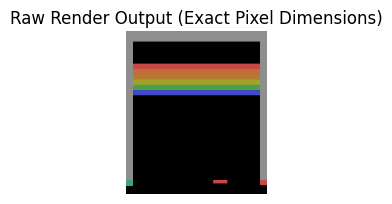

In [8]:
# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="rgb_array")

obs, info = env.reset()
frame = env.render()
frame = frame[20:-5, :, :]

# Calculate figure size in inches to match pixel size
height, width = frame.shape[:2]
print(frame.shape)
print("height: ", height, "width: ", width)
dpi = plt.rcParams['figure.dpi']
figsize = (width / dpi, height / dpi)

# Plot with exact pixel size
plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(frame)
plt.title("Raw Render Output (Exact Pixel Dimensions)")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [9]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #noop, left, and right.  Fire ball (action 1) is not trained

## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

### Create Replay Memory Pickle

In [ ]:

# # # ### Pickle Replay Creator ###
from gymnasium.wrappers import RecordVideo
from config import *


mem_name = 'CircularPERBuffer_for_testing_using_Run13_orig_get_frame'

#create fresh environment
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')
# env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda ep: ep % 20 == 0)  

# Choose whether to use double DQN
double_dqn = False # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

# print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/run13/good_Run13_StdDQN_750K_frames_imprvdBatching_2477_eps.pth")
agent.target_net.load_state_dict(agent.policy_net.state_dict())
agent.epsilon = 0.1

frame = 0   
evaluation_reward = deque(maxlen=evaluation_reward_length)
rewards, episodes = [], []
best_eval_reward = 0
exit_flag = False

for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    fire_ready = True

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Selet Action (with robust check for FIRE action)
        if fire_ready:
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        state = next_state
        next_state, reward, terminations, truncations, info = env.step(action)  
        done = truncations or terminations
        frame_next_state = get_frame(next_state)
        

        history[4, :, :] = frame_next_state
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life

        if lost_life:
            fire_ready = True

        life = info['lives']
        r = reward

        # Store the transition in memory if it was not a FIRE action
        if action in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(action)
            term_state = done or lost_life
            if type(agent.memory).__name__ == "CircularReplayMemoryPER":
                agent.memory.push(agent, deepcopy(frame_next_state), trainable_index, r, term_state)
            else:
                agent.memory.push(deepcopy(frame_next_state), trainable_index, r, term_state)
        # When replay buffer is filled save to pickle and break
        if len(agent.memory) == train_frame:
            print(f"Memory filled, saving pickle file") 
            agent.save_replay_buffer(mem_name, frame)
            exit_flag = True
            break 
        score += reward
        history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame

        if frame % 500 == 0:
            print("DEBUG: len(valid_flags), len(valid_indices), len(td_errors):", sum(agent.memory.valid_flags), len(agent.memory.valid_indices), len(agent.memory.td_errors))

        if done:
            fire_ready = True
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes
            episodes.append(e)

            # print episode information 
            if e % 1 == 0:
                print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "  steps:", step,
                  "  lr:", agent.optimizer.param_groups[0]['lr'], 
                  "  evaluation reward:", np.mean(evaluation_reward))
    if exit_flag:
        break

In [ ]:
# # Start logging
# log_file = "./test_log.txt"
# tee = TeeLogger(log_file)
# sys.stdout = tee
# sys.stderr = tee

# print(f"Logging started. Output will be written to both notebook and {log_file}")



In [ ]:
# # Stop logging safely
# sys.stdout = tee.original_stdout
# sys.stderr = tee.original_stdout
# tee.close()

# print("This goes only to the notebook now.")

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

In [10]:
## Setup Run Name and Memory Paths ##
mem_path = None
mem_path = './checkpoints/CircularPERBuffer_for_testing_using_Run13_orig_get_frame_50498_replay_buffer.pkl'
# mem_path = './checkpoints/Run1_DQN_Serial_20pctExplore_and_Sticky_100000_replay_buffer.pkl'
# mem_path = './checkpoints/Buffer_for_testing_using_Run5_50K_replay_buffer.pkl'
# mem_path = './checkpoints/Buffer_for_testing_using_Run13_new_get_frame_100974_replay_buffer.pkl'
seed = 84

In [ ]:
# log_dir = f"./logs/run{run_num}"
# os.makedirs(log_dir, exist_ok=True)
# log_file = os.path.join(log_dir, f"{run_name}_output.log")
# tee = TeeLogger(log_file)
# sys.stdout = tee
# sys.stderr = tee

# print(f"Logging started. Output will be written to both notebook and {log_file}")

/home/rbisker/miniconda3/envs/wsl_gym/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/c/Users/rbisk/Dropbox/GMU/cs747 Deep Learning/Final_Project/Illinois_hw/videos/run18 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/tmp/ipykernel_225468/2806344182.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

Starting run Run18_Bootstrapped_run17_stickyactions5percent
Instantiating agent
Replay buffer loaded from './checkpoints/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_159356_replay_buffer.pkl' with size 204356
Updated memory capacity to  1000000
[SANITIZER] Fixing 0 invalid or nonpositive TD-errors...
Starting training
episode: 1   frame: 120   score: 0.0   memory length: 204471   epsilon: 0.99977   steps: 120   lr: 0.0005   PER_beta: 0.4001 PER Alpha: 0.5999   reward MA: 0.0   mean loss: 0   mean max Q: 8.3933
episode: 2   frame: 268   score: 1.0   memory length: 204614   epsilon: 0.99949   steps: 148   lr: 0.0005   PER_beta: 0.40021 PER Alpha: 0.59979   reward MA: 0.5   mean loss: 0.03566   mean max Q: 8.2761
episode: 3   frame: 388   score: 0.0   memory length: 204729   epsilon: 0.99926   steps: 120   lr: 0.0005   PER_beta: 0.40031 PER Alpha: 0.59969   reward MA: 0.333   mean loss: 0.03111   mean max Q: 8.6344
episode: 4   frame: 556   score: 1.0   memory length: 204892   epsi

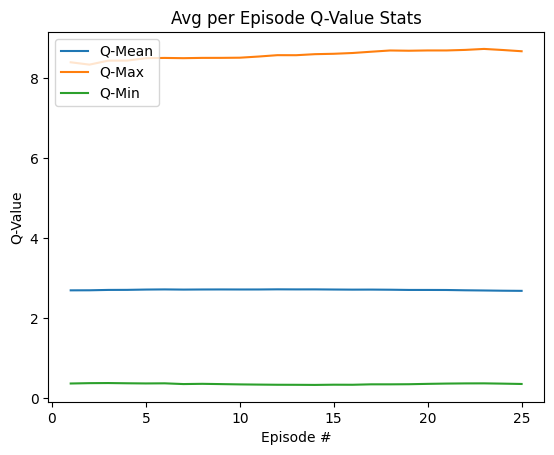

[PER STATS] TD-error mean: 0.06878996214921082 std: 0.1293453911204899 min: 0.0 max: 3.138671875
episode: 26   frame: 4029   score: 4.0   memory length: 208255   epsilon: 0.99234   steps: 258   lr: 0.0005   PER_beta: 0.40322 PER Alpha: 0.59678   reward MA: 0.923   mean loss: 0.02405   mean max Q: 8.7214
episode: 27   frame: 4281   score: 4.0   memory length: 208502   epsilon: 0.99187   steps: 252   lr: 0.0005   PER_beta: 0.40342 PER Alpha: 0.59658   reward MA: 1.037   mean loss: 0.02485   mean max Q: 8.7599
episode: 28   frame: 4401   score: 0.0   memory length: 208617   epsilon: 0.99164   steps: 120   lr: 0.0005   PER_beta: 0.40352 PER Alpha: 0.59648   reward MA: 1.0   mean loss: 0.02389   mean max Q: 8.7814
episode: 29   frame: 4645   score: 3.0   memory length: 208856   epsilon: 0.99117   steps: 244   lr: 0.0005   PER_beta: 0.40372 PER Alpha: 0.59628   reward MA: 1.069   mean loss: 0.02544   mean max Q: 8.5355
episode: 30   frame: 4793   score: 1.0   memory length: 208999   epsilon:

In [ ]:
from config import *
torch.set_float32_matmul_precision('high')

set_seed(seed)
run_num = "18"
name = "Bootstrapped_run17_stickyactions5percent"
run_name = "Run"+ str(run_num) + "_" + name


from config import *
from gymnasium.wrappers import RecordVideo

# choose which Agent to use
from agent import Agent

#create fresh environment
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')  # Use equivalent parameters to BreakoutDeterministic-v4

# setup video recording
def video_trigger(_):
    if len(episodes) == 0:
        return False
    else:
        curr_ep = episodes[-1]
        return (curr_ep > 99 and curr_ep % 100 == 0) 

video_path = f"./videos/run{run_num}"
if not os.path.exists(video_path):
    os.makedirs(video_path)
env = RecordVideo(env, video_folder=video_path, episode_trigger=video_trigger)


print(f"Starting run {run_name}")
train_interval = 1
    
evaluation_reward = deque(maxlen=evaluation_reward_length)
rewards, episodes = [], []
reward = 0
best_eval_reward = curr_mean_reward = last_save_reward = 0

#initialize trackers
## LOSS TRACKERS ##
losses_window = deque(maxlen=10)
loss_history = []
episode_losses = []
loss = mean_loss = 0

# ## Q-VALUE TRACKERS ##
episode_q_means = []
episode_q_maxs = []
episode_q_mins = []
q_mean_window = deque(maxlen=10)
q_max_window = deque(maxlen=10)
q_min_window = deque(maxlen=10)
q_stats_history = {
    'mean': [],
    'max': [],
    'min': [],
    'episode': []
}

# Epsilon Bump Control Variables
plateau_patience = 300
episodes_since_improvement = 0
epsilon_bump = 0.15  # amount to re-increase epsilon
soonest_bump = 2000  # earliest episode to apply epsilon bump

frame = 0
ep_start = 0
training_started_flg = False

print("Instantiating agent")

#Bootstrapped loading run 17
mem_path = './checkpoints/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_159356_replay_buffer.pkl'
checkpoint = torch.load('./checkpoints/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_2000_checkpoint.pt')
agent = Agent(action_size, mem_path)  #use when starting with prefilled replay buffer
agent.memory.capacity = 1_000_000  #update memory capacity
print("Updated memory capacity to ", agent.memory.capacity)
assert sum(agent.memory.valid_flags) == len(agent.memory.valid_indices) == len(agent.memory.td_errors)

td_errors_np = np.array(agent.memory.td_errors, dtype=np.float32)

# Print memory stats before
num_invalid = np.sum(~np.isfinite(td_errors_np)) + np.sum(td_errors_np <= 0)
print(f"[SANITIZER] Fixing {num_invalid} invalid or nonpositive TD-errors...")
# Fix all issues
td_errors_np = np.where(~np.isfinite(td_errors_np) | (td_errors_np <= 0), 1.0, td_errors_np)
agent.memory._priority_cache_dirty = True
# Convert back to list
agent.memory.td_errors = td_errors_np.tolist()
agent.policy_net.load_state_dict(checkpoint['policy_net']) # load partially trained policy network weights
agent.policy_net = torch.compile(agent.policy_net)
agent.target_net.load_state_dict(checkpoint['target_net'])

agent.beta = IS_BETA
agent.alpha = PER_ALPHA

# agent = Agent(action_size, mem_path)  
# agent = Agent(action_size)

#########################
#### LOAD CHECKPOINT ####
# metadata = agent.load_checkpoint("Run8_Stdized_DDQN_750K_frames", 2999)  #Edit episode number
# frame = metadata['global_frame']
# agent.load_replay_buffer("Run8_Stdized_DDQN_750K_frames", 711354)
# ep_start = metadata['global_episode']
# evaluation_reward = metadata['eval_rewards']
# rewards = metadata['rewards']    
# episodes = metadata['episodes']
# losses_window = metadata['last_10_ep_losses']
# loss_history = metadata['loss_tracker']
# training_started_flg = True
########################


start_train_immediate = True
frame_max = TRAINING_STEPS
e = ep_start

while e < EPISODES:
    #limit number of frames for consistent testing
    if frame >= frame_max:
        break

    done = False
    score = 0
    episode_losses = []
    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    fire_ready = True
    no_reward_steps = 0

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        
        #limit number of frames for consitent testing
        if frame >= frame_max:
            break

        step += 1
        frame += 1

        # Selet Action (with robust check for FIRE action)
        if fire_ready:  
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
        state = next_state
        next_state, reward, terminations, truncations, info = env.step(action)  
        done = truncations or terminations
        
        # Failsafe to force reset if no reward for 3000 steps (prevents agent from getting stuck)
        stuck_limit = 3000
        if no_reward_steps > stuck_limit:
            done = True
            print(f"[WARNING] No reward for {stuck_limit} steps, forcing reset | ", "Episode:", e, "  Frame:", frame, ) 
             
        frame_next_state = get_frame(next_state)
             
        # append next state to history
        history[4, :, :] = frame_next_state
        
        # life handling
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            fire_ready = True
        life = info['lives']
        
        r = reward
        if r == 0:
            no_reward_steps += 1
        else:
            no_reward_steps = 0 

        # Store the transition in replay buffer if it was not a FIRE action
        
        if action in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(action)
            term_state = done or lost_life
            if type(agent.memory).__name__ == "CircularReplayMemoryPER":
                # print("[DEBUG] Using CircularReplayMemoeryPER.push()")
                # agent.memory.push(agent, deepcopy(frame_next_state), trainable_index, r, term_state)  # for use when model is used to estimate new TD-errors
                mean_td = np.mean(agent.recent_td_errors) if len(agent.recent_td_errors) > 200 else 1.0
                agent.memory.push(frame_next_state.copy(), trainable_index, r, term_state, mean_recent_td_error=mean_td)
            else:
                agent.memory.push(frame_next_state.copy(), trainable_index, r, term_state)
        
        # Start training after random sample generation
        if training_started_flg == False and (frame == train_frame or (start_train_immediate and frame == 1)):
            print("Starting training")
            training_started_flg = True
            e = ep_start  #reset episode counter when training starts
        if(training_started_flg): 
            if frame % train_interval == 0: # Use adaptive training interval
                loss, q_stats = agent.train_policy_net()
                episode_losses.append(loss)
                episode_q_means.append(q_stats['q_mean'])
                episode_q_maxs.append(q_stats['q_max'])
                episode_q_mins.append(q_stats['q_min'])
            # Update the target network
            if (frame % (train_interval * update_target_network_frequency)) == 0:
                agent.update_target_net()
                print("Target network updated at frame: ", frame)
        
        # Update score and history
        score += reward
        history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame

        ## DEBUG ##
        if frame % 1000 == 0 and len(agent.memory.td_errors) > 0:
            agent.memory.log_td_error_distribution()
            
        if done:
            e += 1
            fire_ready = True
            evaluation_reward.append(score)            
            

            # print episode information every X episodes
            if e % 1 == 0:
                print("episode:", e, "  frame:", frame, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", round(agent.epsilon, 5), 
                  "  steps:", step, "  lr:", agent.optimizer.param_groups[0]['lr'], "  PER_beta:", round(agent.beta,5), "PER Alpha:", round(agent.alpha,5),
                  "  reward MA:", round(np.mean(evaluation_reward), 3), 
                  "  mean loss:", round(mean_loss, 5), "  mean max Q:", round(np.mean(episode_q_maxs), 4))
                #   "  latest step Q max:", round(q_stats['q_max'], 4))


            
            if training_started_flg:



                episodes.append(e)
                rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes

                # # adapt training interval to agent performance
                # if np.mean(evaluation_reward) < 8:
                #     train_interval = 4
                # elif np.mean(evaluation_reward) < 15:
                #     train_interval = 2
                # else:
                #     train_interval = 1

                ## DEBUG ##
                # Check TD-error distribution in Replay Buffer
                if e>0 and e % 100 == 0:
                    agent.memory.log_td_error_distribution()

                # save rolling loss everages every X episodes
                if episode_losses:
                    mean_loss = sum(episode_losses) / len(episode_losses)
                    losses_window.append(mean_loss)
                    if e > 9 and e % 10 == 0:
                        loss_history.append((np.mean(losses_window), e))

                # save rolling Q-score stat averages
                q_mean_window.append(np.mean(episode_q_means))
                q_max_window.append(np.mean(episode_q_maxs))
                q_min_window.append(np.mean(episode_q_mins))
                q_stats_history['mean'].append(np.mean(q_mean_window))
                q_stats_history['max'].append(np.mean(q_max_window))
                q_stats_history['min'].append(np.mean(q_min_window))
                q_stats_history['episode'].append(e)
                episode_q_means = []
                episode_q_maxs = []
                episode_q_mins = []

                # plot the rewards every X episodes
                if e > 0 and e % 50 == 0:
                    # clear_output(wait=True)
                    pylab.plot(episodes, rewards, 'b')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Episode Scores') 
                    pylab.title('DQN w PER & Cropped Scoreboard \n Scores')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_scores.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()
                
                # every X episodes, plot the mean losses
                if e > 0 and e % 50 == 0:
                    x = [entry[1] for entry in loss_history]
                    y = [entry[0] for entry in loss_history]
                    pylab.plot(x, y, 'r')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Loss per Episode') 
                    pylab.title('DQN w PER & Cropped Scoreboard \n Loss')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_losses.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()

                # plot Q-value statistics every X episodes
                if e > 0 and e % 25 == 0:
                    pylab.plot(q_stats_history['episode'], q_stats_history['mean'], label='Q-Mean')
                    pylab.plot(q_stats_history['episode'], q_stats_history['max'], label='Q-Max')
                    pylab.plot(q_stats_history['episode'], q_stats_history['min'], label='Q-Min')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Q-Value')
                    pylab.title('Avg per Episode Q-Value Stats')
                    pylab.legend(loc='upper left')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_Qstats.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()


                    ## DEBUG ##
                    # print(f"[PLOT DEBUG] Last 5 q_means: {q_stats_history['mean'][-5:]}")

                # Checkpoint the training process every X episodes 
                if e > 0 and e % 250 == 0:
                    metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history, q_stats_history, q_mean_window, \
                                               q_max_window, q_min_window, agent.epsilon, alpha=agent.alpha, beta=agent.beta)
                    agent.save_checkpoint(metadata, run_name, e)
                if e > 0 and e % 500 == 0:
                    agent.save_replay_buffer(run_name, frame)

                # Check if reward has improved
                curr_mean_reward = np.mean(evaluation_reward)
                if curr_mean_reward > best_eval_reward:
                    best_eval_reward = curr_mean_reward
                    episodes_since_improvement = 0
                else:
                    episodes_since_improvement += 1
                
                # save model if it is good
                if curr_mean_reward > 8 and curr_mean_reward > (1.05 * last_save_reward):
                    model_path = f"./save_model/run{run_num}/good_{run_name}_{e}_eps.pth"
                    os.makedirs(os.path.dirname(model_path), exist_ok=True)
                    torch.save(agent.policy_net.state_dict(), model_path)
                    print(f"[SAVED MODEL] {model_path}")
                    last_save_reward = curr_mean_reward
               
                # # # Apply epsilon bump if plateauing
                # if e > soonest_bump and episodes_since_improvement >= plateau_patience:
                #     if agent.epsilon < agent.epsilon_max:
                #         agent.epsilon = min(agent.epsilon + epsilon_bump, agent.epsilon_max)
                #         print(f"[BUMP] Epsilon bumped to {agent.epsilon:.4f} after {plateau_patience} stagnant episodes.")
                #     episodes_since_improvement = 0  # Reset counter after bump



# Checkpoint the model at the end of training loop
metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history, q_stats_history, q_mean_window, \
                            q_max_window, q_min_window, agent.epsilon, alpha=agent.alpha, beta=agent.beta)
agent.save_checkpoint(metadata, run_name, e)
agent.save_replay_buffer(run_name, frame)

print("Training complete")



In [ ]:
# End logging
sys.stdout = tee.ipython_stdout
tee.close()

In [ ]:

# === Load checkpoint files ===
ddqn_ckpt = torch.load("./checkpoints/Run12_DDQN_750K_frames_imprvdBatching_3007_checkpoint.pt")
dqn_ckpt  = torch.load("./checkpoints/Run13_StdDQN_750K_frames_imprvdBatching_2673_checkpoint.pt")

# === Extract metadata ===
ddqn_meta = ddqn_ckpt["metadata"]
dqn_meta = dqn_ckpt["metadata"]

# # === Extract episode indices and rolling mean rewards ===
# ddqn_episodes = ddqn_meta["episodes"]
# ddqn_rewards = ddqn_meta["rewards"]

# dqn_episodes = dqn_meta["episodes"]
# dqn_rewards = dqn_meta["rewards"]

# # === Plot ===
# plt.figure(figsize=(10, 6))
# plt.plot(dqn_episodes, dqn_rewards, label="DQN", color="red")
# plt.plot(ddqn_episodes, ddqn_rewards, label="DDQN", color="blue")
# plt.xlabel("Episode #", fontweight="bold")
# plt.ylabel("Mean Episode Score (Moving Avg)", fontweight="bold")
# plt.legend(loc = "upper left")
# # Main title
# pylab.text(0.5, 1.05, 'Std DQN vs DDQN Scores',
#            ha='center', va='bottom', transform=pylab.gca().transAxes,
#            fontsize=14, fontweight='semibold')

# # Subtitle (smaller font)
# pylab.text(0.5, 1.01, '(750K training steps)',
#            ha='center', va='bottom', transform=pylab.gca().transAxes,
#            fontsize=10, color='gray')


# plot_path = f"./presentation_assets/DQN_vs_DDQN_750K_steps_SCORES.png"
# os.makedirs(os.path.dirname(plot_path), exist_ok=True)
# pylab.savefig(plot_path, bbox_inches='tight')
# print(f"[SAVED PLOT] {plot_path}")
# plt.show()


# # === Extract loss data ===
ddqn_loss_history = ddqn_meta["loss_tracker"]
dqn_loss_history = dqn_meta["loss_tracker"]

ddqn_episodes = [entry[1] for entry in ddqn_loss_history]
ddqn_losses = [entry[0] for entry in ddqn_loss_history]

dqn_episodes = [entry[1] for entry in dqn_loss_history]
dqn_losses = [entry[0] for entry in dqn_loss_history]

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(dqn_episodes, dqn_losses, label="DQN", color="red")
plt.plot(ddqn_episodes, ddqn_losses, label="DDQN", color="blue")
plt.xlabel("Episode #", fontweight="bold")
plt.ylabel("Mean Episode Loss (Moving Avg)", fontweight="bold")
plt.legend(loc = "best")
# Main title
pylab.text(0.5, 1.05, 'Std DQN vs DDQN Huber Loss',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=14, fontweight='semibold')

# Subtitle (smaller font)
pylab.text(0.5, 1.01, '(750K training steps)',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=10, color='gray')


plot_path = f"./presentation_assets/DQN_vs_DDQN_750K_steps_LOSSES.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
pylab.savefig(plot_path, bbox_inches='tight')
print(f"[SAVED PLOT] {plot_path}")
plt.show()


In [ ]:
# chkpt = torch.load("./checkpoints/Run12_DDQN_750K_frames_imprvdBatching_3007_checkpoint.pt")
from model import DQN_DualBranch
action_size = len(TRAINABLE_ACTIONS)
model = DQN_DualBranch(action_size)
model.eval()

#create dummy input for model
dummy_input = torch.rand(BATCH_SIZE, 6, 84, 84)

#export to ONNX
torch.onnx.export(model, dummy_input, "Branched Network.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
                  opset_version=11)

print("ONNX model exported successfully!")


## Timediff Frames

Instead of using a 4 frame history to train the model, here we will feed the model the 4 frames plus the "diff" between each of the 4 frames to help isolate the ball position which is the most important thing for the model to learn

# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

### Play Game in Window or Save Video

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

# set random seed to sync visual and recorded game
seed = 55
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load and setup Agent
print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/run3/good_Run3_DDQN_Serial_InvTimeEpsilon_ddqn_886_eps.pth")
agent.policy_net.eval()
agent.epsilon = 0  # Set agent to only exploit the best action


# Create environments
env_human = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="human")
# env_record = RecordVideo(env_record, video_folder="./videos", episode_trigger=lambda e: True)

# Reset to seed
state_h, _ = env_human.reset(seed=seed)
state_h = do_random_actions(env_human, 20)


# Setup History
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state_h, HISTORY_SIZE)

done = False
fire_ready = True
life = number_lives
score = 0
step = 0

while not done:
    step += 1

    # Select action
    if fire_ready:
        print(f"[DEBUG] Agent is not acting — sending FIRE at step {step}")
        action = 1
        fire_ready = False
    else:
        model_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        action = TRAINABLE_ACTIONS[model_action]

    # Step the environment
    state_h, reward, term_h, trunc_h, info = env_human.step(action)
    done = term_h or trunc_h

    # update history
    frame_next_state = get_frame(state_h)
    history[4, :, :] = frame_next_state
    history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
    
    # check if life has been lost
    lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
    if lost_life:
        print(f"[DEBUG] Lost life detected at step {step}")
        fire_ready = True
    life = info['lives']
    
    # keep track of score
    score += reward # update total score

    
env_human.close()


### Play Game Rendered in Jupyter Notebook

In [ ]:
from IPython.display import display as ipythondisplay, clear_output

def show_state_live(frame, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(frame)
    plt.title(f"Step: {step} {info}")
    plt.axis('off')
    clear_output(wait=True)
    ipythondisplay(plt.gcf())

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo


# set random seed to sync visual and recorded game
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load and setup Agent
# Choose whether to use double DQN
double_dqn = False # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

#Initialize agent
print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/Run1_serial/good_breakout_dqn_1256_eps.pth")
agent.policy_net.eval()
agent.epsilon = 0  # Set agent to only exploit the best action


# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="rgb_array")
# Use RecordVideo to save the video to the "videos" directory
# env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda episode_id: True)

# Reset the environment
state, _ = env.reset(seed=seed)

# Setup History
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)

#Initialize variables
step = 0
done = False
fire_ready = True
life = number_lives
score = 0

while not done:

    # Render the current frame live in the notebook
    show_state_live(state, step)   

    # Select action
    if fire_ready:
        action = 1
        fire_ready = False
    else:
        model_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        action = TRAINABLE_ACTIONS[model_action]

    # Step the environment
    next_state, reward, term, trunc, info = env.step(action)
    done = term or trunc

    # update history
    frame_next_state = get_frame(state)
    history[4, :, :] = frame_next_state
    history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
    
    # check if life has been lost
    lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
    if lost_life:
        fire_ready = True  
        # do_random_actions(env_human, 30) #IMPT: introduce randomness to game and paddle position before next life
    life = info['lives']
    
    # keep track of score
    score += reward # update total score

    state = next_state
    step += 1

    

env.close()

## Model Comparison Tester

In [ ]:
from utils import *
from config import *
import gymnasium as gym



# Load and setup Agent
# Choose which agent class to load
from agent import Agent
# from agent_timediff import Agent

# 50 unique, fixed seeds
seeds = [765,817,53,705,990,511,236,661,654,418,804,968,1,749,125,293,985,574, 
         447,948,687,317,280,645,927,842,309,616,717,930,778,323,595,798,195,11,
         483,316,690,951,196,307,906,558,516,844,410,965,371,886]


#Initialize agent
print("Instantiating agent")
agent = Agent(action_size)
# agent.load_policy_net("./save_model/run12/good_Run12_DDQN_750K_frames_imprvdBatching_2319_eps.pth")
agent.load_policy_net("./save_model/run13/good_Run13_StdDQN_750K_frames_imprvdBatching_2477_eps.pth")
# agent.load_policy_net("./save_model/run14/good_Run14_StdDQN_750Kfr_timediff_new_get_frame_2425_eps.pth")
agent.target_net.load_state_dict(agent.policy_net.state_dict())
agent.target_net.eval()
agent.policy_net.eval()
agent.epsilon = 0.05  # Set agent to use model action 95% of the time for robustness


# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False, render_mode="rgb_array")
# Use RecordVideo to save the video to the "videos" directory
# video_path = f"./videos/testing/run13"
# if not os.path.exists(video_path):
#     os.makedirs(video_path)
# env = RecordVideo(env, video_folder=video_path, episode_trigger=lambda e: True)


scores = []

for e, seed in enumerate(seeds):
    set_seed(seed)
    # Reset the environment
    state, _ = env.reset(seed=seed)

    # Setup History
    history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
    get_init_state(history, state, HISTORY_SIZE)  #non cropped version
    # new_get_init_state(history, state, HISTORY_SIZE)  #cropped version

    #Initialize variables
    step = 0
    done = False
    fire_ready = True
    life = number_lives
    score = 0

    while not done:
        
        # Selet Action (with robust check for FIRE action)
        if fire_ready:
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
    
        next_state, reward, term, trunc, info = env.step(action)
        done = term or trunc
        # update total score
        score += reward 

        # update history
        history[4, :, :] = get_frame(next_state)  #non cropped version
        # history[4, :, :] = new_get_frame(next_state)  #cropped version
        history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
        
        # check if life has been lost
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            fire_ready = True  
        life = info['lives']
        
        
        step += 1
    
    print("episode:", e, "  seed:", seed, "  score:", score, "  epsilon:", round(agent.epsilon, 5), 
    "  steps:", step)
    
    scores.append(score)

env.close()
print("Mean Score: ", np.mean(scores))
print("Std Score: ", np.std(scores))
print("Max Score: ", np.max(scores))
print("Min Score: ", np.min(scores))
print("Median Score: ", np.median(scores))

env.close()

## SCRATCH

In [ ]:
for i in range(4):
    print(i)


In [ ]:
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)
env.reset()
next_state, reward, terminations, truncations, info = env.step(torch.tensor([[1]]))
done = truncations or terminations
print("reward: ", reward)
print("done: ", done)
print("info: ", info)
print(next_state.shape)

In [ ]:
print(env.action_space)
print("Expected type:", type(env.action_space.sample()))

In [ ]:
print("agent memory type: ", type(agent.memory.memory[0]))
print("agent memory[0]: ", agent.memory.memory[0])

In [15]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cuda.is_built())
print("Triton available:", torch._inductor.config.is_triton_enabled())


2.4.1+cu118
11.8
True


AttributeError: torch._inductor.config.is_triton_enabled does not exist

In [16]:
import torch
import torch.nn as nn
import time

class Simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 16, 3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 84 * 84, 10)
        )

    def forward(self, x):
        return self.net(x)

model = Simple().cuda()
compiled_model = torch.compile(model)

x = torch.randn(1, 4, 84, 84, device='cuda')
with torch.no_grad():
    out = compiled_model(x)

print("Compile + inference worked:", out.shape)

c:\Users\rbisk\anaconda3\envs\gym\lib\site-packages\torch\_inductor\compile_fx.py:150: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


BackendCompilerFailed: backend='inductor' raised:
RuntimeError: Cannot find a working triton installation. More information on installing Triton can be found at https://github.com/openai/triton

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


### Debug Harnesses

In [ ]:
import numpy as np
import random
import memory as mem

# Use a small capacity for easy debugging
capacity = 10
history_size = 3
memory = mem.CircularReplayMemoryPER(capacity, history_size)

# Push 30 fake transitions (will cause multiple wraps)
for step in range(30):
    frame = np.ones((84, 84), dtype=np.uint8) * step
    action = random.randint(0, 3)
    reward = random.random()
    done = (step % 7 == 0)  # Random done flag every few steps

    memory.push(frame, action, reward, done)

    num_flags = sum(memory.valid_flags)
    num_indices = len(memory.valid_indices)

    if num_flags != num_indices:
        print(f"❌ Mismatch at step {step}:")
        print(f"   valid_flags count = {num_flags}")
        print(f"   valid_indices count = {num_indices}")
        print(f"   position = {memory.position}")
        print(f"   size = {memory.size}")
        print(f"   flags: {memory.valid_flags}")
        print(f"   valid_indices: {memory.valid_indices}")
        raise AssertionError("valid_flags and valid_indices out of sync")

print("✅ All checks passed — valid_flags == valid_indices through all pushes.")


In [ ]:
import memory as RepBuff
import traceback

# Configuration
capacity = 1000
history_size = 4
batch_size = 32


# Configuration
capacity = 1000
history_size = 4
batch_size = 16
alpha = 0.6

# Initialize memory
memory = RepBuff.CircularReplayMemoryPER(capacity=capacity, history_size=history_size)

# Track previous cache values for comparison
previous_probs = None

# Simulate a bunch of pushes
for step in range(1500):
    print(f"Step {step}, ")
    frame = np.ones((84, 84), dtype=np.uint8) * step
    action = random.randint(0, 3)
    reward = random.random()
    done = (step % 50 == 0)


    memory.push(frame, action, reward, done)

    # Occasionally update TD-errors
    if step > 100 and len(memory.valid_indices) >= batch_size:
        indices = random.sample(range(len(memory.valid_indices)), min(len(memory.valid_indices), batch_size))
        print(len(indices))
        new_td = np.random.rand(batch_size).astype(np.float32)
        memory.update_td_errors(indices, new_td)

    # Check probability stability and cache correctness
    if len(memory.valid_indices) >= batch_size:
        try:
            # Trigger cache update and record internal state
            probs = memory.get_sampling_probs(memory.valid_indices)
            total_prob = probs.sum()

            # Cache sanity checks
            assert hasattr(memory, "_cached_probs"), "Missing cached_probs"
            assert memory._cached_probs is not None, "Cached probs not populated"
            assert np.allclose(memory._cached_probs.sum(), 1.0, atol=1e-4), "Cached probs do not sum to 1"

            # Compare with previous cache state
            if previous_probs is not None:
                if np.array_equal(previous_probs, memory._cached_probs):
                    print(f"[DEBUG] Cache unchanged at step {step} — may be okay if no new TDs pushed")
                else:
                    print(f"[DEBUG] Cache updated at step {step}")
            previous_probs = memory._cached_probs.copy()

            if np.isnan(total_prob) or total_prob == 0:
                print("[ERROR] Total probability is invalid at step:", step)
                print("TD errors:", [memory.td_errors[i] for i in memory.valid_indices[:10]])
                print("Sampling probs:", probs[:10])
                raise AssertionError("Invalid sampling distribution")

        except Exception as e:
            print("[EXCEPTION]", str(e))
            traceback.print_exc()
            break

print("✅ Debug harness completed without total_priority = 0 and with valid cache behavior")
